In [10]:
# Fetch benchmark results

import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import requests
import os
from dotenv import load_dotenv

load_dotenv()

USER = os.getenv('ELASTIC_USER')
PASS = os.getenv('ELASTIC_PASS')

if not USER or not PASS:
    raise Exception('Elastic credentials not found')

URL = 'https://elastic.joyutils.org/distributors-benchmark/_search?size=10000'

# Set up the query data
query_data = {
  "query": {
    "term": {
      "version.keyword": "0.2.0"
    }
  }
}

# Make the GET request
response = requests.get(
    URL,
    auth=(USER, PASS),
    headers={'Content-Type': 'application/json'},
    data=json.dumps(query_data)
)

# create output directory if it doesn't exist
if not os.path.exists('output'):
    os.makedirs('output')

# Check if the request was successful
if response.status_code == 200:
    benchmarks_data = response.json()

    # Save the data to a JSON file
    with open('output/benchmarks.json', 'w') as file:
        json.dump(benchmarks_data, file)
else:
    raise Exception("Failed to retrieve data: ", response.status_code)

In [11]:
# Load the benchmark data

file_path = 'output/benchmarks.json'
with open(file_path, 'r') as file:
    data = json.load(file)

# Extract benchmark data
benchmark_data = [entry['_source'] for entry in data['hits']['hits']]
df = pd.DataFrame(benchmark_data)

print(f'Number of entries: {len(df)}')

df.head()

Number of entries: 3522


,normalizedDownloadSpeed,urlOrigin,downloadSpeedBps,ttfb,cacheStatus,referenceLatency,version,downloadTime,processingTime,url,...,totalRequestTime,geo,uid,downloadSize,referenceDownloadSpeedBps,sourceIp,sslTime,dnsLookupTime,timestamp,id
0,0.845426,https://dist1.joyutils.org,7.775143e+07,217.7,hit,14.950115,0.2.0,2572.3,217.7,https://dist1.joyutils.org/distributor/api/v1/...,...,2790.0,"{'region_iso_code': 'RU-SPE', 'continent_name'...",771e5037-fc0b-41e6-a903-ea88e3792536,25000000.0,9.196712e+07,95.161.151.242,0.0,0,2023-11-16T13:05:51.511Z,NaN
1,0.857629,https://jstrm.numisma.cc,7.887368e+07,379.1,hit,14.950115,0.2.0,2535.7,379.1,https://jstrm.numisma.cc/distributor/api/v1/as...,...,2914.8,"{'region_iso_code': 'RU-SPE', 'continent_name'...",771e5037-fc0b-41e6-a903-ea88e3792536,25000000.0,9.196712e+07,95.161.151.242,0.0,0,2023-11-16T13:05:51.511Z,NaN
2,1.000000,https://distributor.adovrn.xyz,9.201748e+07,213.4,hit,14.950115,0.2.0,2173.5,213.4,https://distributor.adovrn.xyz/distributor/api...,...,2386.9,"{'region_iso_code': 'RU-SPE', 'continent_name'...",771e5037-fc0b-41e6-a903-ea88e3792536,25000000.0,9.196712e+07,95.161.151.242,0.0,0,2023-11-16T13:05:51.511Z,NaN
3,0.221640,https://dwg.joystream.name,2.038362e+07,1445.6,hit,14.950115,0.2.0,9811.8,1445.6,https://dwg.joystream.name/distributor/api/v1/...,...,11257.4,"{'region_iso_code': 'RU-SPE', 'continent_name'...",771e5037-fc0b-41e6-a903-ea88e3792536,25000000.0,9.196712e+07,95.161.151.242,0.0,0,2023-11-16T13:05:51.511Z,NaN
4,0.110225,https://distributor-node.mms.team,1.013705e+07,1084.8,hit,14.950115,0.2.0,19729.6,1084.8,https://distributor-node.mms.team/distributor/...,...,20814.4,"{'region_iso_code': 'RU-SPE', 'continent_name'...",771e5037-fc0b-41e6-a903-ea88e3792536,25000000.0,9.196712e+07,95.161.151.242,0.0,0,2023-11-16T13:05:51.511Z,NaN


In [12]:
# Load operators metadata and populate geo distance

from geopy.distance import geodesic
from urllib.parse import urlparse

query = '''
query {
  distributionBucketOperators {
    id
    metadata {
      nodeEndpoint
      nodeLocation {
        coordinates {
          latitude
          longitude
        }
      }
    }
  }
}
'''
graphql_url = 'https://query.joystream.org/graphql'

# Fetching the data
response = requests.post(graphql_url, json={'query': query})
data = response.json()

# Processing node data
nodes = [
    {
        'urlOrigin': f"{urlparse(node['metadata']['nodeEndpoint']).scheme}://{urlparse(node['metadata']['nodeEndpoint']).netloc}",
        'nodeLat': node['metadata']['nodeLocation']['coordinates']['latitude'],
        'nodeLng': node['metadata']['nodeLocation']['coordinates']['longitude']
    }
    for node in data['data']['distributionBucketOperators']
]

dist1Entry = next((item for item in nodes if item['urlOrigin'] == 'https://dist1.joyutils.org'), None)
adovrnEntry = next((item for item in nodes if item['urlOrigin'] == 'https://distributor.adovrn.xyz'), None)

nodes.append({
    'urlOrigin': 'https://gateway.joyutils.org',
    'nodeLat': dist1Entry['nodeLat'],
    'nodeLng': dist1Entry['nodeLng']
})
nodes.append({
    'urlOrigin': 'https://ru.joystreamstats.live',
    'nodeLat': adovrnEntry['nodeLat'],
    'nodeLng': adovrnEntry['nodeLng']
})
nodes_df = pd.DataFrame(nodes)
nodes_df.head(15)

# Define a function to calculate distance
def calculate_distance(user_coords, node_coords):
    return geodesic(user_coords, node_coords).kilometers

df = df.merge(nodes_df, on='urlOrigin', how='left', suffixes=('', '_y'))
df.drop(df.filter(regex='_x$').columns,axis=1, inplace=True)
df.drop(df.filter(regex='_y$').columns,axis=1, inplace=True)
 
# Calculate distance for each entry
df['nodeDistanceKm'] = df.apply(
    lambda x: calculate_distance(
        (x['geo']['location']['lat'], x['geo']['location']['lon']), 
        (x['nodeLat'], x['nodeLng'])
    ),
    axis=1
)

# Drop unnecessary columns
df.drop(['nodeLat', 'nodeLng'], axis=1, inplace=True)

df.head()

,normalizedDownloadSpeed,urlOrigin,downloadSpeedBps,ttfb,cacheStatus,referenceLatency,version,downloadTime,processingTime,url,...,geo,uid,downloadSize,referenceDownloadSpeedBps,sourceIp,sslTime,dnsLookupTime,timestamp,id,nodeDistanceKm
0,0.845426,https://dist1.joyutils.org,7.775143e+07,217.7,hit,14.950115,0.2.0,2572.3,217.7,https://dist1.joyutils.org/distributor/api/v1/...,...,"{'region_iso_code': 'RU-SPE', 'continent_name'...",771e5037-fc0b-41e6-a903-ea88e3792536,25000000.0,9.196712e+07,95.161.151.242,0.0,0,2023-11-16T13:05:51.511Z,NaN,1686.646414
1,0.857629,https://jstrm.numisma.cc,7.887368e+07,379.1,hit,14.950115,0.2.0,2535.7,379.1,https://jstrm.numisma.cc/distributor/api/v1/as...,...,"{'region_iso_code': 'RU-SPE', 'continent_name'...",771e5037-fc0b-41e6-a903-ea88e3792536,25000000.0,9.196712e+07,95.161.151.242,0.0,0,2023-11-16T13:05:51.511Z,NaN,1833.490343
2,1.000000,https://distributor.adovrn.xyz,9.201748e+07,213.4,hit,14.950115,0.2.0,2173.5,213.4,https://distributor.adovrn.xyz/distributor/api...,...,"{'region_iso_code': 'RU-SPE', 'continent_name'...",771e5037-fc0b-41e6-a903-ea88e3792536,25000000.0,9.196712e+07,95.161.151.242,0.0,0,2023-11-16T13:05:51.511Z,NaN,0.454633
3,0.221640,https://dwg.joystream.name,2.038362e+07,1445.6,hit,14.950115,0.2.0,9811.8,1445.6,https://dwg.joystream.name/distributor/api/v1/...,...,"{'region_iso_code': 'RU-SPE', 'continent_name'...",771e5037-fc0b-41e6-a903-ea88e3792536,25000000.0,9.196712e+07,95.161.151.242,0.0,0,2023-11-16T13:05:51.511Z,NaN,5652.030646
4,0.110225,https://distributor-node.mms.team,1.013705e+07,1084.8,hit,14.950115,0.2.0,19729.6,1084.8,https://distributor-node.mms.team/distributor/...,...,"{'region_iso_code': 'RU-SPE', 'continent_name'...",771e5037-fc0b-41e6-a903-ea88e3792536,25000000.0,9.196712e+07,95.161.151.242,0.0,0,2023-11-16T13:05:51.511Z,NaN,8972.304501


In [13]:
import uuid

# Filling missing 'id' values
df['id'] = df.groupby('referenceDownloadSpeedBps')['id'].transform(
    lambda x: x.fillna(str(uuid.uuid4())) if x.isnull().any() else x
)
df = df[df['referenceDownloadSpeedBps'] >= 5000000]
df = df[df['ttfb'] >= 0]
df = df[df['totalRequestTime'] >= 0]

print(f'Number of entries after filtering: {len(df)}')
print(f'Number of tests: {len(df["id"].unique())}')

def apply_custom_region_key(x):
    continent = x['continent']
    
    if continent == 'Asia':
        country = x['country']
        lng = x['geo']['location']['lon']
        if country == 'India' or country == 'Bangladesh' or country == 'Nepal' or country == 'Bhutan' or country == 'Myanmar':
            return 'South Asia'
        elif lng > 90:
            return 'Southeast Asia'
        else:
            return 'West Asia'
    
    return continent

df['continent'] = df['geo'].apply(lambda x: x.get('continent_name') if isinstance(x, dict) else None)
df['country'] = df['geo'].apply(lambda x: x.get('country_name') if isinstance(x, dict) else None)
df['region'] = df.apply(apply_custom_region_key, axis=1)
df['downloadSpeedMbps'] = df['downloadSpeedBps'].apply(lambda x: x / 1000000 if x else None)
df['normalizedDownloadSpeed'] = df.apply(lambda x: x['downloadSpeedBps'] / x['referenceDownloadSpeedBps'] if x['referenceDownloadSpeedBps'] else None, axis=1)

media_df = df[df['objectType'] == 'media']
thumbnail_df = df[df['objectType'] == 'thumbnail']

media_df.head()

Number of entries after filtering: 3423
Number of tests: 206


,normalizedDownloadSpeed,urlOrigin,downloadSpeedBps,ttfb,cacheStatus,referenceLatency,version,downloadTime,processingTime,url,...,sourceIp,sslTime,dnsLookupTime,timestamp,id,nodeDistanceKm,continent,country,region,downloadSpeedMbps
0,0.845426,https://dist1.joyutils.org,7.775143e+07,217.7,hit,14.950115,0.2.0,2572.3,217.7,https://dist1.joyutils.org/distributor/api/v1/...,...,95.161.151.242,0.0,0,2023-11-16T13:05:51.511Z,c8868da8-e2b5-4728-9d3d-cce4b9c0681d,1686.646414,Europe,Russia,Europe,77.751429
1,0.857629,https://jstrm.numisma.cc,7.887368e+07,379.1,hit,14.950115,0.2.0,2535.7,379.1,https://jstrm.numisma.cc/distributor/api/v1/as...,...,95.161.151.242,0.0,0,2023-11-16T13:05:51.511Z,c8868da8-e2b5-4728-9d3d-cce4b9c0681d,1833.490343,Europe,Russia,Europe,78.873684
2,1.000548,https://distributor.adovrn.xyz,9.201748e+07,213.4,hit,14.950115,0.2.0,2173.5,213.4,https://distributor.adovrn.xyz/distributor/api...,...,95.161.151.242,0.0,0,2023-11-16T13:05:51.511Z,c8868da8-e2b5-4728-9d3d-cce4b9c0681d,0.454633,Europe,Russia,Europe,92.017483
3,0.221640,https://dwg.joystream.name,2.038362e+07,1445.6,hit,14.950115,0.2.0,9811.8,1445.6,https://dwg.joystream.name/distributor/api/v1/...,...,95.161.151.242,0.0,0,2023-11-16T13:05:51.511Z,c8868da8-e2b5-4728-9d3d-cce4b9c0681d,5652.030646,Europe,Russia,Europe,20.383620
4,0.110225,https://distributor-node.mms.team,1.013705e+07,1084.8,hit,14.950115,0.2.0,19729.6,1084.8,https://distributor-node.mms.team/distributor/...,...,95.161.151.242,0.0,0,2023-11-16T13:05:51.511Z,c8868da8-e2b5-4728-9d3d-cce4b9c0681d,8972.304501,Europe,Russia,Europe,10.137053


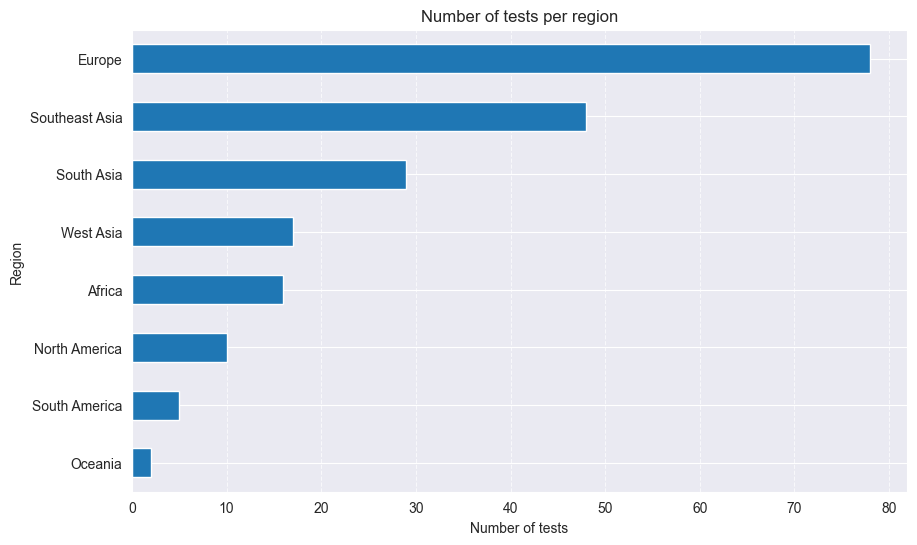

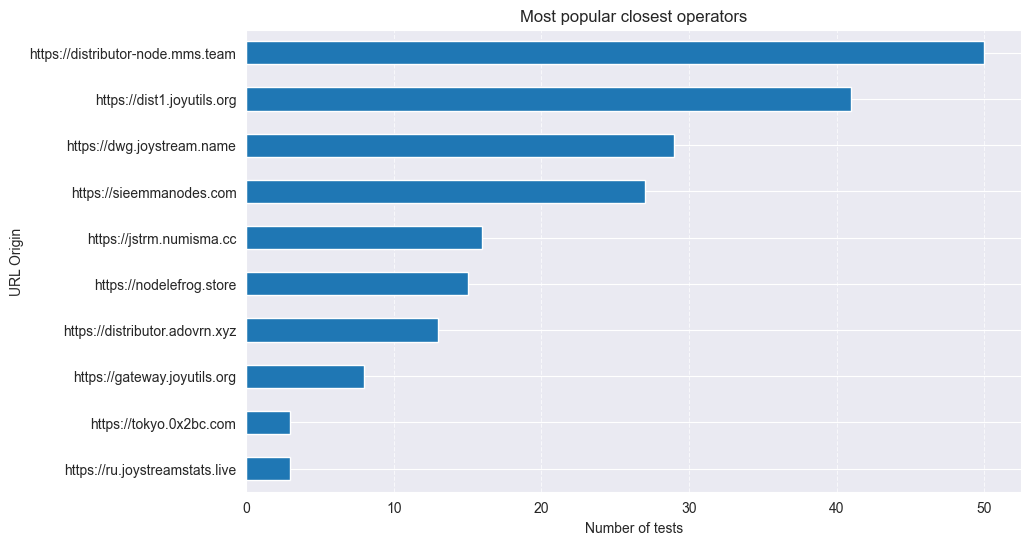

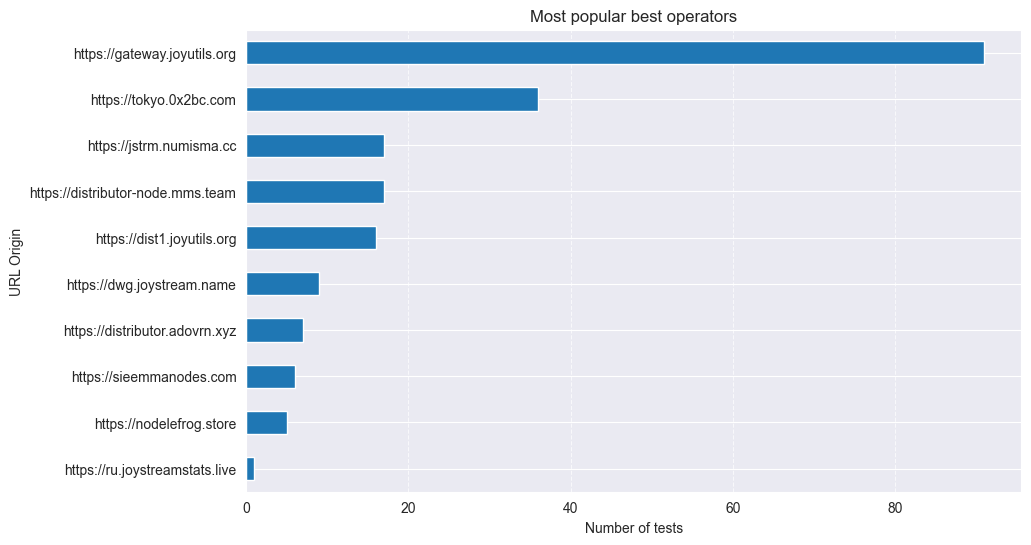

In [14]:
# Get grouped statistics

grouped_media = media_df.groupby('id').apply(lambda x: x.to_dict(orient='records')).to_dict()
grouped_thumbnail = thumbnail_df.groupby('id').apply(lambda x: x.to_dict(orient='records')).to_dict()

combined_data = []
for id_key in set(grouped_media.keys()).union(grouped_thumbnail.keys()):
    combined_data.append({
        'id': id_key,
        'mediaTests': grouped_media.get(id_key, []),
        'thumbnailTests': grouped_thumbnail.get(id_key, [])
    })
    
for entry in combined_data:
    media_tests = entry['mediaTests']
    thumbnail_tests = entry['thumbnailTests']
    
    media_speeds = [test['downloadSpeedMbps'] for test in media_tests]
    thumbnail_times = [test['totalRequestTime'] for test in thumbnail_tests]
    
    entry['bestMediaSpeedMbps'] = max(media_speeds) if media_speeds else None
    entry['bestMediaSpeedUrlOrigin'] = media_tests[media_speeds.index(max(media_speeds))]['urlOrigin'] if media_speeds else None
    entry['bestMediaNormalizedSpeed'] = max([test['normalizedDownloadSpeed'] for test in media_tests]) if media_tests else None
    
    entry['bestThumbnailTime'] = min(thumbnail_times) if thumbnail_times else None
    entry['bestThumbnailTimeUrlOrigin'] = thumbnail_tests[thumbnail_times.index(min(thumbnail_times))]['urlOrigin'] if thumbnail_times else None
    
    closest_media_test = min(media_tests, key=lambda x: x['nodeDistanceKm']) if media_tests else None
    closest_thumbnail_test = min(thumbnail_tests, key=lambda x: x['nodeDistanceKm']) if thumbnail_tests else None

    if closest_media_test:
        entry['closestMediaSpeedMbps'] = closest_media_test['downloadSpeedMbps']
        entry['closestMediaUrlOrigin'] = closest_media_test['urlOrigin']
        entry['closestMediaNormalizedSpeed'] = closest_media_test['normalizedDownloadSpeed']
    
    if closest_thumbnail_test:
        entry['closestThumbnailTime'] = closest_thumbnail_test['totalRequestTime']
        entry['closestThumbnailUrlOrigin'] = closest_thumbnail_test['urlOrigin']
    
    entry['country'] = media_tests[0]['country'] if media_tests else None
    entry['continent'] = media_tests[0]['continent'] if media_tests else None
    entry['region'] = media_tests[0]['region'] if media_tests else None

grouped_df = pd.DataFrame(combined_data)

# plot most popular regions (include labels for region and numbers) using horizontal bar
regions_tests = grouped_df.groupby('region')['id'].count().sort_values(ascending=True)
plt.figure(figsize=(10, 6))
regions_tests.plot(kind='barh')
plt.xlabel('Number of tests')
plt.ylabel('Region')
plt.title('Number of tests per region')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.savefig('output/tests_per_region.png', bbox_inches='tight', dpi=300)
plt.show()
plt.close()

# plot most popular closest operators
closest_operators = grouped_df.groupby('closestMediaUrlOrigin')['id'].count().sort_values(ascending=True)
plt.figure(figsize=(10, 6))
closest_operators.plot(kind='barh')
plt.xlabel('Number of tests')
plt.ylabel('URL Origin')
plt.title('Most popular closest operators')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.savefig('output/closest_operators.png', bbox_inches='tight', dpi=300)
plt.show()

# plot most popular best operators
best_operators = grouped_df.groupby('bestMediaSpeedUrlOrigin')['id'].count().sort_values(ascending=True)
plt.figure(figsize=(10, 6))
best_operators.plot(kind='barh')
plt.xlabel('Number of tests')
plt.ylabel('URL Origin')
plt.title('Most popular best operators')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.savefig('output/best_operators.png', bbox_inches='tight', dpi=300)
plt.show()


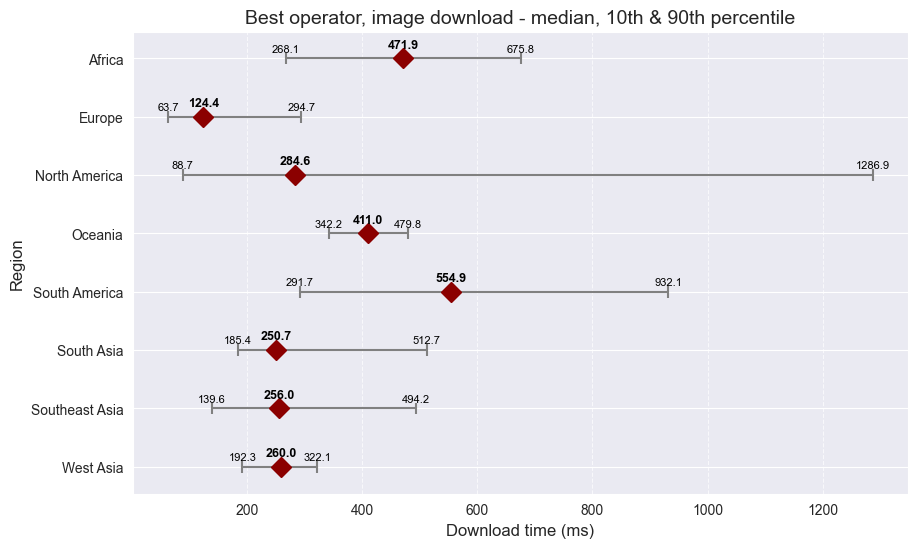

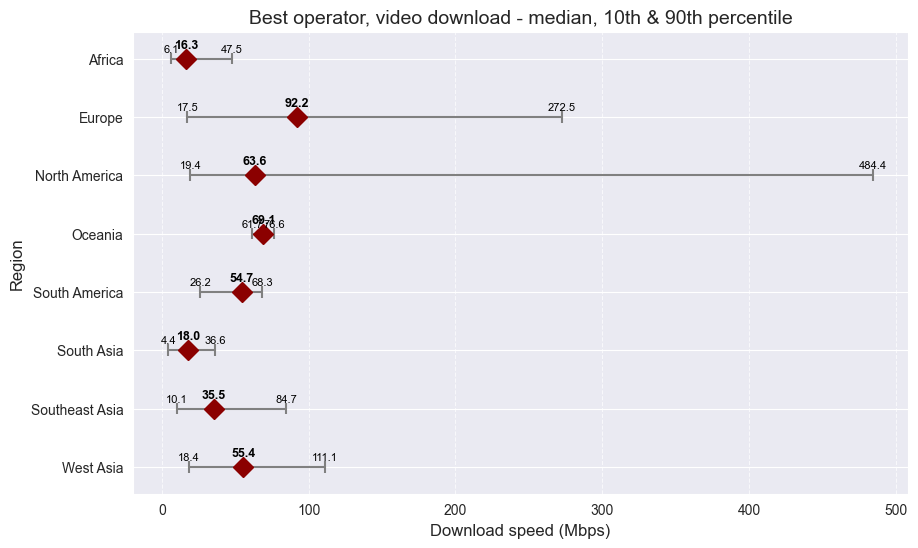

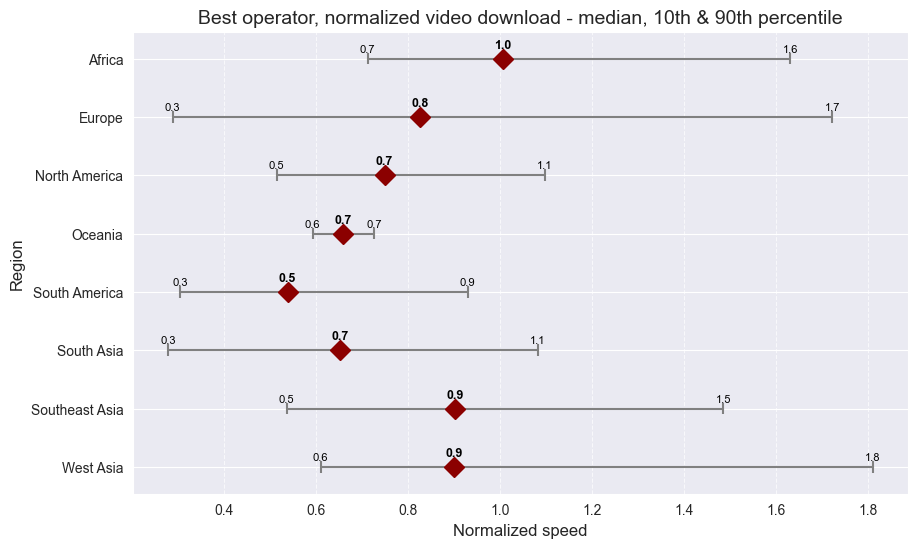

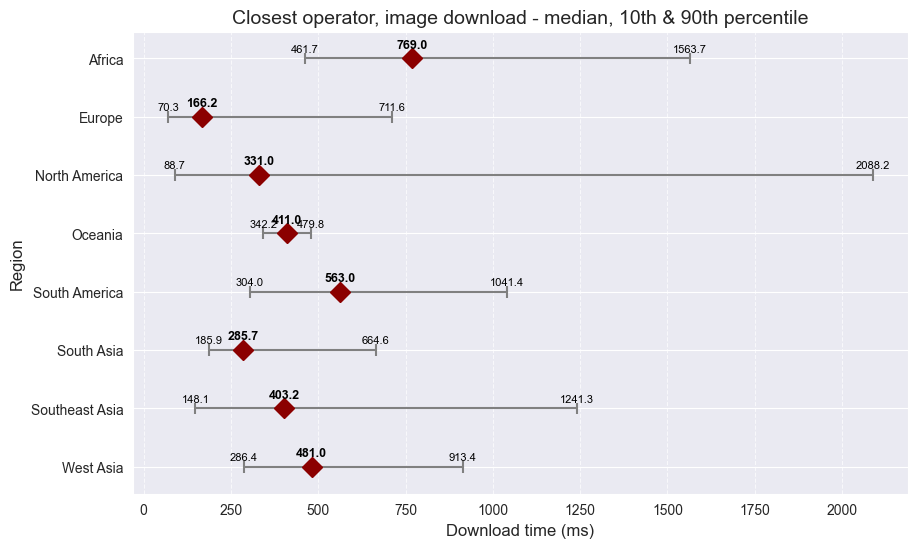

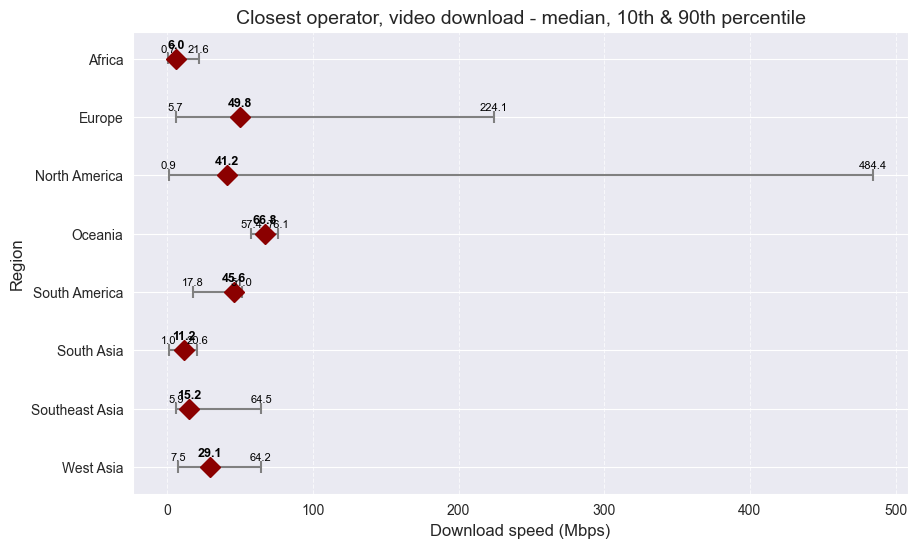

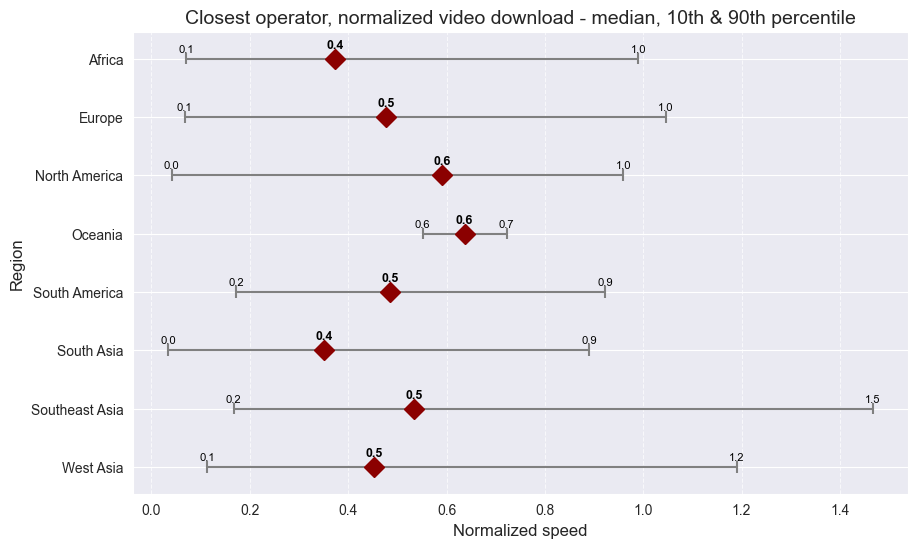

In [15]:
def plot_and_save(plot_data_df, title, value_label, path):
    agg_df = plot_data_df.agg(
        median='median', 
        percentile_10=lambda x: np.percentile(x, 10) if len(x) > 0 else None, 
        percentile_90=lambda x: np.percentile(x, 90) if len(x) > 0 else None
    )
    agg_df = agg_df.sort_index(ascending=False)
    agg_df.columns = ['Median', '10th Percentile', '90th Percentile']
    
    plt.figure(figsize=(10, 6))
    
    for y_pos, (index, row) in enumerate(agg_df.iterrows()):
        plt.plot([row['10th Percentile'], row['90th Percentile']], [index, index], color='grey', markersize=10)
    
        # Vertical lines for 10th and 90th percentiles
        plt.vlines([row['10th Percentile'], row['90th Percentile']], y_pos - 0.1, y_pos + 0.1, color='grey')
    
        # Labels for 10th and 90th percentiles
        plt.text(row['10th Percentile'], y_pos + 0.25, f'{row["10th Percentile"]:.1f}', ha='center', va='top', color='black', fontsize=8)
        plt.text(row['90th Percentile'], y_pos + 0.25, f'{row["90th Percentile"]:.1f}', ha='center', va='top', color='black', fontsize=8)
    
        # Median marker and label
        plt.plot([row['Median']], [index], marker='D', color='darkred', markersize=10)
        plt.text(row['Median'], y_pos + 0.13, f'{row["Median"]:.1f}', ha='center', va='bottom', color='black', fontweight='bold', fontsize=9)
        
    # Customizing the plot
    plt.yticks(range(len(agg_df)), agg_df.index)
    plt.xlabel(value_label, fontsize=12)
    plt.ylabel('Region', fontsize=12)
    plt.title(title, fontsize=14)
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)
    plt.savefig(f'output/{path}', bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

plot_and_save(grouped_df.groupby('region')['bestThumbnailTime'], title='Best operator, image download - median, 10th & 90th percentile', value_label='Download time (ms)', path='best_thumbnail_time.png')
plot_and_save(grouped_df.groupby('region')['bestMediaSpeedMbps'], title='Best operator, video download - median, 10th & 90th percentile', value_label='Download speed (Mbps)', path='best_media_speed.png')
plot_and_save(grouped_df.groupby('region')['bestMediaNormalizedSpeed'], title='Best operator, normalized video download - median, 10th & 90th percentile', value_label='Normalized speed', path='best_media_speed_normalized.png')

plot_and_save(grouped_df.groupby('region')['closestThumbnailTime'], title='Closest operator, image download - median, 10th & 90th percentile', value_label='Download time (ms)', path='closest_thumbnail_time.png')
plot_and_save(grouped_df.groupby('region')['closestMediaSpeedMbps'], title='Closest operator, video download - median, 10th & 90th percentile', value_label='Download speed (Mbps)', path='closest_media_speed.png')
plot_and_save(grouped_df.groupby('region')['closestMediaNormalizedSpeed'], title='Closest operator, normalized video download - median, 10th & 90th percentile', value_label='Normalized speed', path='closest_media_speed_normalized.png')

# grouped_df.head()

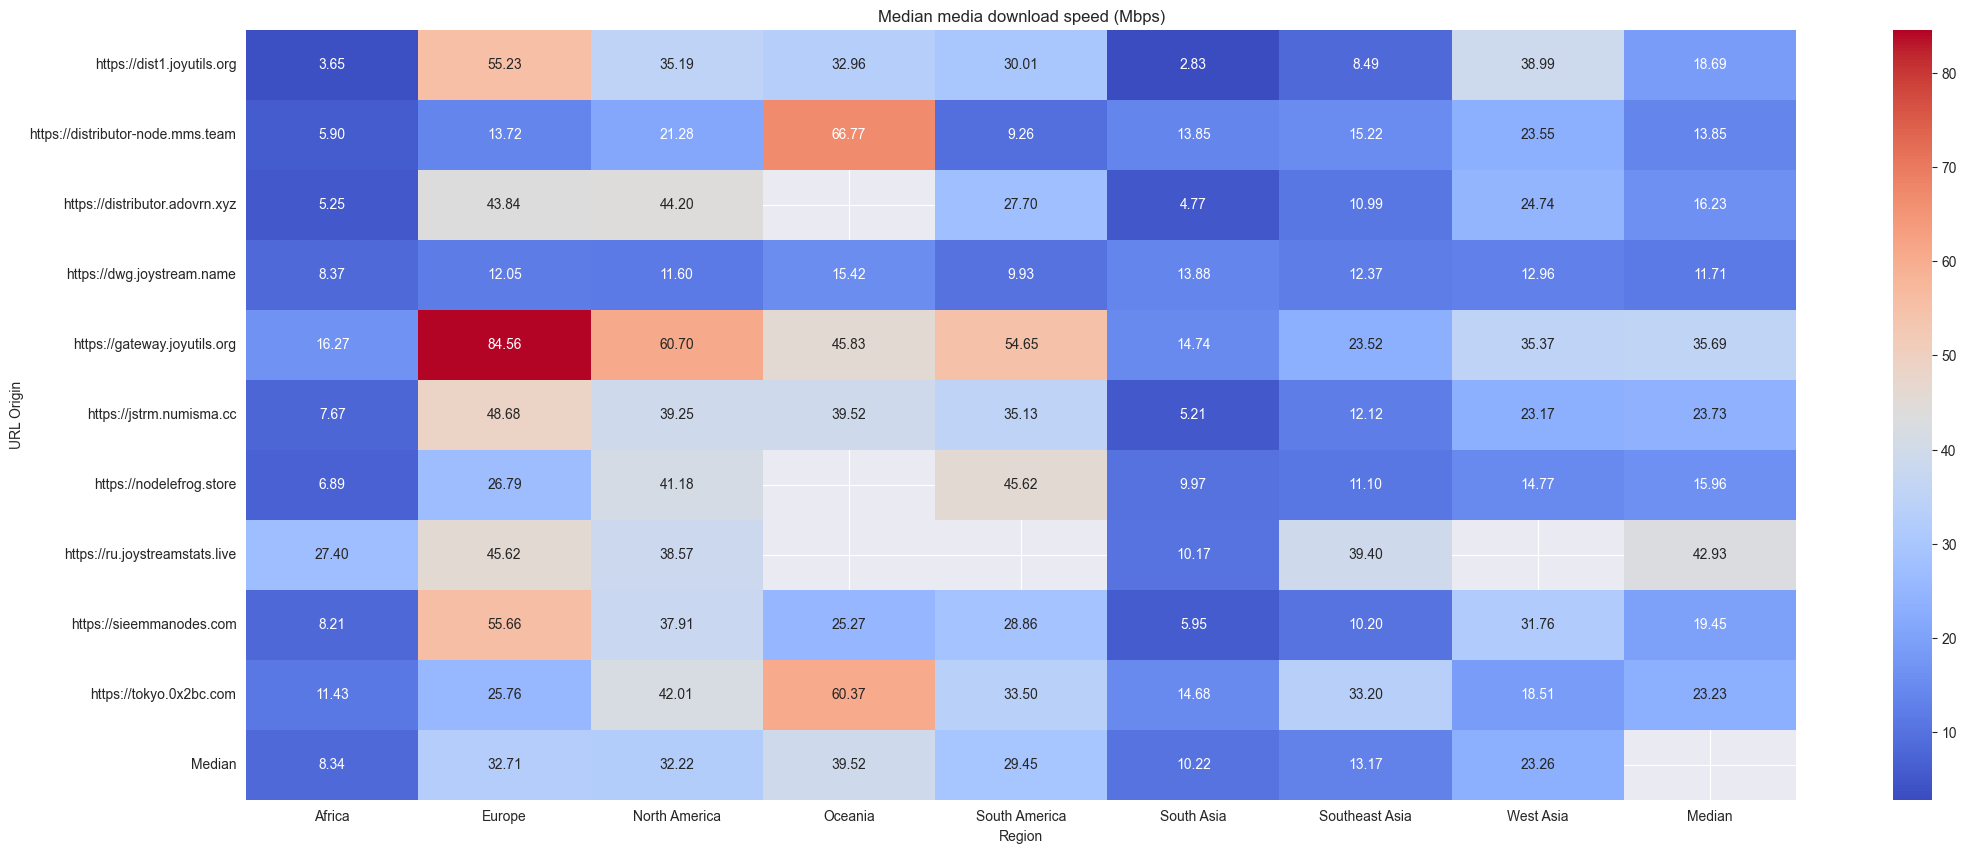

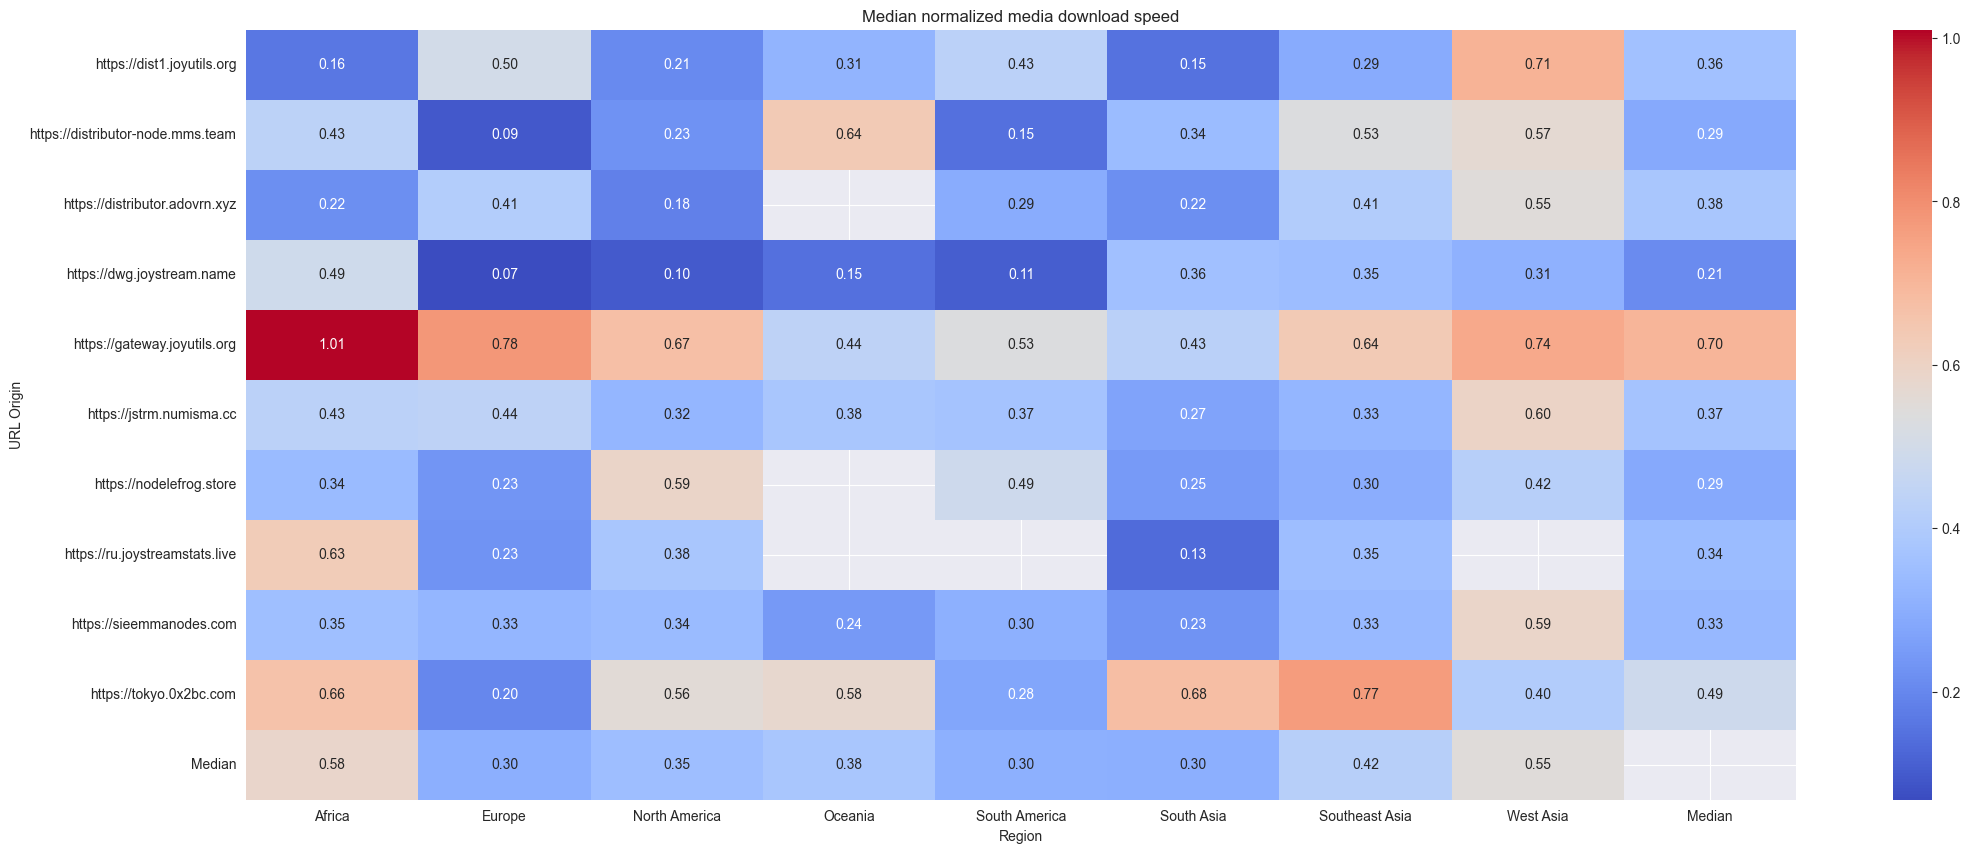

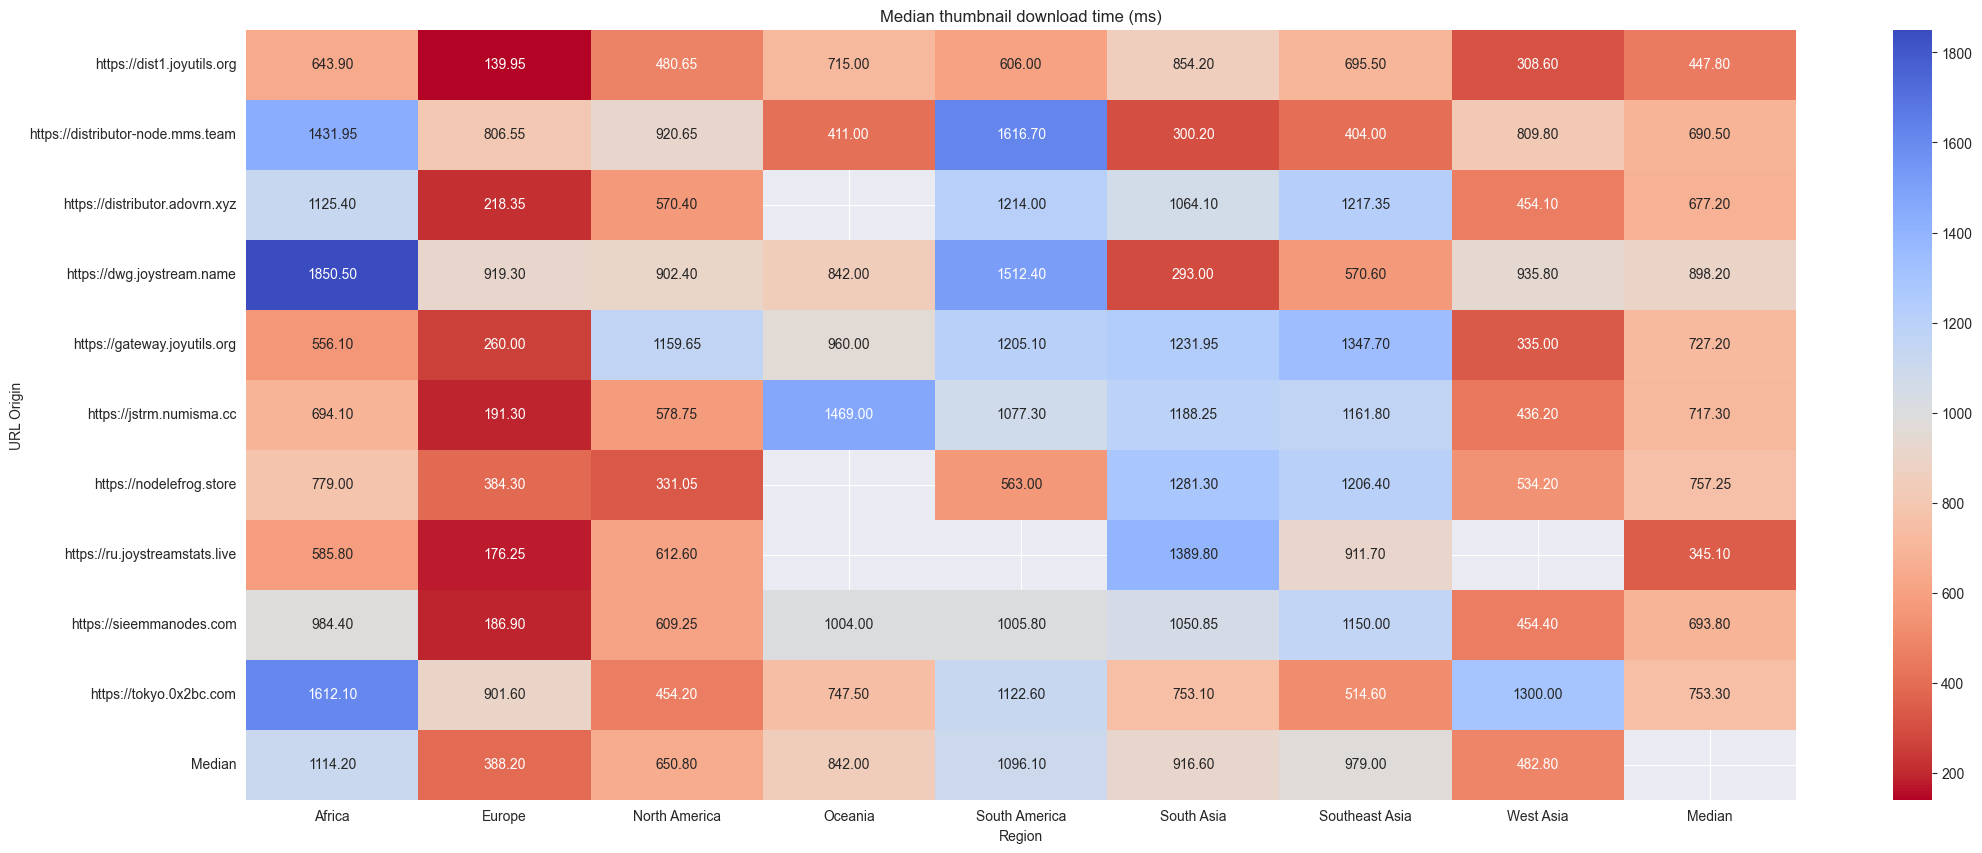

In [16]:
def create_and_save_heatmap(data, title, path, reverse=False):
    plt.figure(figsize=(25, 10))
    sns.heatmap(data, annot=True, cmap="coolwarm_r" if reverse else "coolwarm", fmt=".2f")
    plt.title(title)
    plt.ylabel('URL Origin')
    plt.xlabel('Region')
    plt.savefig(f'output/{path}', bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

# Heatmap for media objects
plot_data_media = media_df[['urlOrigin', 'region', 'downloadSpeedMbps']]
pivot_media = plot_data_media.pivot_table(index='urlOrigin', columns='region', values='downloadSpeedMbps', aggfunc='median')
url_origin_avg_media = plot_data_media.groupby('urlOrigin')['downloadSpeedMbps'].median()
region_avg_media = plot_data_media.groupby('region')['downloadSpeedMbps'].median()
pivot_media['Median'] = url_origin_avg_media
pivot_media.loc['Median'] = region_avg_media
create_and_save_heatmap(pivot_media, 'Median media download speed (Mbps)', 'heatmap_media.png')

# Heatmap for normalized media objects
plot_data_media_normalized = media_df[['urlOrigin', 'region', 'normalizedDownloadSpeed']]
pivot_media_normalized = plot_data_media_normalized.pivot_table(index='urlOrigin', columns='region', values='normalizedDownloadSpeed', aggfunc='median')

url_origin_avg_media_normalized = plot_data_media_normalized.groupby('urlOrigin')['normalizedDownloadSpeed'].median()
region_avg_media_normalized = plot_data_media_normalized.groupby('region')['normalizedDownloadSpeed'].median()
pivot_media_normalized['Median'] = url_origin_avg_media_normalized
pivot_media_normalized.loc['Median'] = region_avg_media_normalized
create_and_save_heatmap(pivot_media_normalized, 'Median normalized media download speed', 'heatmap_media_normalized.png')

# # Heatmap for thumbnail objects
plot_data_thumbnail = thumbnail_df[['urlOrigin', 'region', 'totalRequestTime']]
pivot_thumbnail = plot_data_thumbnail.pivot_table(index='urlOrigin', columns='region', values='totalRequestTime', aggfunc='median')
url_origin_avg_thumbnail = plot_data_thumbnail.groupby('urlOrigin')['totalRequestTime'].median()
region_avg_thumbnail = plot_data_thumbnail.groupby('region')['totalRequestTime'].median()
pivot_thumbnail['Median'] = url_origin_avg_thumbnail
pivot_thumbnail.loc['Median'] = region_avg_thumbnail
create_and_save_heatmap(pivot_thumbnail, 'Median thumbnail download time (ms)', 'heatmap_thumbnail.png', reverse=True)